In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchinfo import summary

# read MNIST training data
df = pd.read_csv('./data/mnist_train.csv')
X = df.iloc[:, 1:].to_numpy() / 255.0       # values are scaled to be between 0 and 1
y = df.iloc[:, 0].to_numpy()                # labels of images

# divide the data into batches (we loop through the batches in training)
batch_size = 32
batches = int(np.ceil(X.shape[0]/batch_size))
X_batched = np.array_split(X, batches)
y_batched = np.array_split(y, batches)

X_batched = torch.tensor(X_batched,dtype=torch.float32)
y_batched = torch.tensor(y_batched,dtype=torch.int64)

/tmp/ipykernel_137004/554381706.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /croot/pytorch_1686931851744/work/torch/csrc/utils/tensor_new.cpp:245.)
  X_batched = torch.tensor(X_batched,dtype=torch.float32)


Here we repeat the same steps but with a CNN

In [24]:
import torch.nn as nn
import torch.nn.functional as F
#
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # same padding
            nn.SELU(),
            nn.MaxPool2d(2, 2) #28 -> 14
            
        ) 

        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # same padding
            nn.SELU(),
            nn.MaxPool2d(2, 2, padding=1) #14 -> 8
        )

        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # same padding
            nn.SELU(),
            nn.MaxPool2d(2, 2) #8 -> 4
        )
        # Decoder
        self.dec1 = nn.Sequential(
            # Start with the output of the encoder (4x4 feature maps), then upsample back to 8x8.
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.SELU()
        )

        self.dec2 = nn.Sequential(
            # Upsample from 8x8 to 14x14. We need output_padding=1 to go from 7 to 14.
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=3, output_padding=1),
            nn.SELU(),
        )

        self.dec3 = nn.Sequential(
            # Finally, upsample from 14x14 to 28x28. No output_padding is needed here.
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.SELU()
        )

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        return x

model = CNNAutoencoder()

In [25]:
loss_function = nn.MSELoss()
def train(X_batched,y_batched):
    optimizer = optim.Adam(model.parameters())
    loss_values = []
    running_loss = 0.0
    for epoch in range(2):
        for b in range(batches):
            optimizer.zero_grad()
            inputs, labels = X_batched[b], X_batched[b]
            labels = labels.view(-1, 1, 28, 28)
            inputs = inputs.view(-1, 1, 28, 28)  # Reshape the inputs
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if b%100 ==99:
                print(f'[{epoch+1}, {b+1:5d}] loss: {running_loss/100:.3f}')
                loss_values.append(running_loss/100)
                running_loss = 0.0
    
    return loss_values


loss_values = train(X_batched,y_batched)
print("Finished Training")

[1,   100] loss: 0.053
[1,   200] loss: 0.023
[1,   300] loss: 0.017
[1,   400] loss: 0.014
[1,   500] loss: 0.013
[1,   600] loss: 0.012
[1,   700] loss: 0.011
[1,   800] loss: 0.011
[1,   900] loss: 0.010
[1,  1000] loss: 0.010
[1,  1100] loss: 0.009
[1,  1200] loss: 0.009
[1,  1300] loss: 0.009
[1,  1400] loss: 0.009
[1,  1500] loss: 0.008
[1,  1600] loss: 0.008
[1,  1700] loss: 0.008
[1,  1800] loss: 0.008
[2,   100] loss: 0.013
[2,   200] loss: 0.007
[2,   300] loss: 0.007
[2,   400] loss: 0.007
[2,   500] loss: 0.007
[2,   600] loss: 0.007
[2,   700] loss: 0.006
[2,   800] loss: 0.006
[2,   900] loss: 0.006
[2,  1000] loss: 0.006
[2,  1100] loss: 0.006
[2,  1200] loss: 0.006
[2,  1300] loss: 0.006
[2,  1400] loss: 0.006
[2,  1500] loss: 0.006
[2,  1600] loss: 0.006
[2,  1700] loss: 0.005
[2,  1800] loss: 0.005
Finished Training


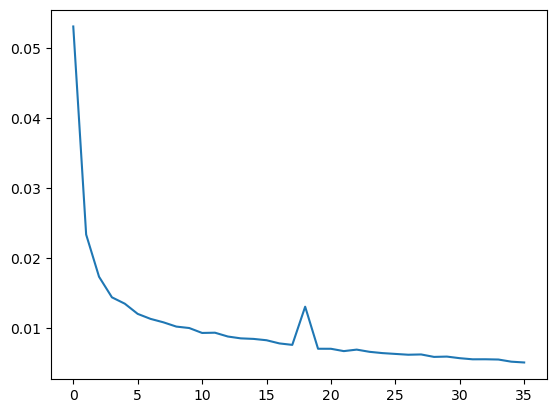

In [26]:
plt.plot(loss_values)

Here the images seem to be more accurate reconstructions than Q1. Moreover the loss is much lower at 0.005. that is 1/5th of the loss of the previous model

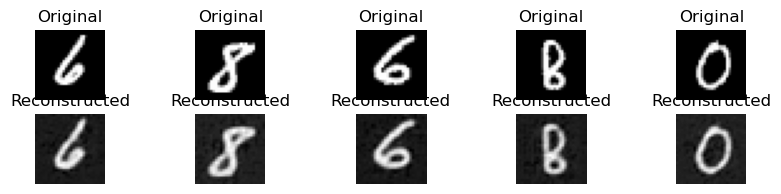

In [30]:
def test_reconstruction(model, X_batched, num_examples=5):
    # Turn the model to evaluation mode
    model.eval()
    # Randomly select a few examples
    indices = np.random.choice(len(X), num_examples)
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_examples, figsize=(10, 2))
    for i, idx in enumerate(indices):
        original = X[idx]
        original_img = original.reshape(28, 28)
        axes[0, i].imshow(original_img, cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        # Convert to tensor and add an additional batch dimension
        original_tensor = torch.tensor(original, dtype=torch.float32).view(-1, 1, 28, 28)
        # Get the model output for the selected example
        reconstructed_tensor = model(original_tensor)
        # The output tensor may need to be detached and converted back to numpy
        reconstructed = reconstructed_tensor.detach().numpy().reshape(28, 28)
        axes[1, i].imshow(reconstructed, cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    plt.show()

# Call the test function
test_reconstruction(model, X_batched)